# Model Fit

In [1]:
import pandas as pd
import numpy as np
import h5py

from sklearn import model_selection, linear_model, metrics, pipeline, preprocessing

# Set random seed
np.random.seed(42)

In [2]:
# Load the data and separate the id's
X_data  = pd.read_hdf("cat.hdf5", "train")
y_data  = pd.read_hdf("cat.hdf5", "train_target")
X_test  = pd.read_hdf("cat.hdf5", "test")

# Store and drop data ID
data_id = X_data.loc[:, "id"]
test_id = X_test.loc[:, "id"]

X_data.drop(columns="id", inplace=True)
X_test.drop(columns="id", inplace=True)

In [3]:
with h5py.File("cat.hdf5", "r") as f:
    data_columns = f['data_columns'][()]
    one_hot_columns = f['one_hot_columns'][()]

data_columns = list(data_columns.astype("U"))
one_hot_columns = list(one_hot_columns.astype("U"))

In [4]:
# Split the data with labels into training and validation.
X_train, X_val, y_train, y_val = model_selection.train_test_split(X_data, y_data, test_size=0.3)

In [5]:
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape)

(210000, 291) (210000,) (90000, 291) (90000,) (200000, 291)


## Column selector in the pipeline
Adapted from https://ramhiser.com/post/2018-04-16-building-scikit-learn-pipeline-with-pandas-dataframe/

In [6]:
from sklearn.base import BaseEstimator, TransformerMixin
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)

        try:
            return X[self.columns]
        except KeyError:
            cols_error = list(set(self.columns) - set(X.columns))
            raise KeyError("The DataFrame does not include the columns: %s" % cols_error)

In [7]:
# Let's instantiate our two selectors
label_encode_selector = ColumnSelector(data_columns)
one_hot_selector = ColumnSelector(one_hot_columns)

In [8]:
print(label_encode_selector.fit_transform(X_train).columns)
print(one_hot_selector.fit_transform(X_train).columns)

Index(['bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4', 'nom_0', 'nom_1', 'nom_2',
       'nom_3', 'nom_4', 'nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9',
       'nom_5_freq', 'nom_6_freq', 'nom_7_freq', 'nom_8_freq', 'nom_9_freq',
       'ord_0', 'ord_1', 'ord_2', 'ord_3', 'ord_4', 'ord_5', 'day_sin',
       'day_cos', 'month_sin', 'month_cos'],
      dtype='object')
Index(['bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4', 'nom_0_Green', 'nom_0_Red',
       'nom_1_Polygon', 'nom_1_Square', 'nom_1_Star',
       ...
       'ord_5_186', 'ord_5_187', 'ord_5_188', 'ord_5_189', 'ord_5_190',
       'ord_5_191', 'day_sin', 'day_cos', 'month_sin', 'month_cos'],
      dtype='object', length=275)


## Premilinary Model Selection
We use these model without tuning to see their basic performance on the dataset, and use this to decide whether it is even worth tuning.

In [9]:
from sklearn.linear_model import LogisticRegressionCV

# SVC does not scale up; but we try them anyway
from sklearn.svm import SVC

from sklearn.ensemble import RandomForestClassifier

# Likely wont work; this is not Gaussian or even approx Gaussian
from sklearn.naive_bayes import GaussianNB

from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

In [74]:
svc = pipeline.Pipeline([
        ("one_hot_selector", one_hot_selector),
        ("min_max_scaler", preprocessing.MinMaxScaler()),
        ("clf", SVC(gamma='auto',probability=True))
        ])

logistic = pipeline.Pipeline([    
        ("one_hot_selector", one_hot_selector),
        ("min_max_scaler", preprocessing.MinMaxScaler()),
        ("clf", LogisticRegressionCV(cv=5,solver='lbfgs',max_iter=10000,n_jobs=-1))
        ])

rf = pipeline.Pipeline([
        ("label_encode_selector", label_encode_selector),
        ("clf", RandomForestClassifier(n_jobs=-1))
        ])

nb = pipeline.Pipeline([
        ("one_hot_selector", one_hot_selector),
        ("min_max_scaler", preprocessing.MinMaxScaler()),
        ("clf", GaussianNB())
        ])

sgd = pipeline.Pipeline([
        ("one_hot_selector", one_hot_selector),
        ("min_max_scaler", preprocessing.MinMaxScaler()),
    # We use log so that it does not predict 0/1 only
        ("clf", SGDClassifier(loss="log",n_jobs=-1))
        ])

decision_tree = pipeline.Pipeline([
        ("label_encode_selector", label_encode_selector),
        ("clf", DecisionTreeClassifier())
        ])

In [23]:
import time

# This function evaluates a model use a subset of training data,
# and a validation set. Also time the training and prediction.
def get_score(model, limit_train_size=None, limit_val_size=None):
    if limit_train_size == None:
        X_t = X_train
        y_t = y_train
    else:
        X_t = X_train[:limit_train_size]
        y_t = y_train[:limit_train_size]
        
    if limit_train_size == None:
        X_t = X_val
        y_t = y_val
    else:
        X_t = X_val[:limit_val_size]
        y_t = y_val[:limit_val_size]
    
    t0 = time.time()
    model.fit(X_t, y_t)
    
    
    y_val_pred = model.predict_proba(X_val)[:, 1]
    val_score = metrics.roc_auc_score(y_val, y_val_pred)

    y_train_pred = model.predict_proba(X_train)[:, 1]
    train_score = metrics.roc_auc_score(y_train, y_train_pred)
    
    t1 = time.time()
    
    dt = t1 - t0
    
    return (train_score, val_score, dt)

In [25]:
clf_name = ["svc", "logistic", "rf",
            "nb", "sgd", "decision_tree"]
clfs = [svc, logistic, rf, nb, sgd, decision_tree]

train_auc = []
val_auc = []
time_elapsed = []

for i, clf in enumerate(clfs):
    print("Evaluating %s." % clf_name[i])
    train, val, t = get_score(clf,
        limit_train_size=1000, limit_val_size=1000)
    train_auc.append(train)
    val_auc.append(val)
    time_elapsed.append(t)

result = pd.DataFrame(
    {
        "clf": clf_name,
        "Train AUC": train_auc,
        "Validation AUC": val_auc,
        "Time": time_elapsed
    }
)
result

Evaluating svc.
Evaluating logistic.
Evaluating rf.
Evaluating nb.
Evaluating sgd.
Evaluating decision_tree.


,clf,Train AUC,Validation AUC,Time
0,svc,0.688313,0.691235,41.718692
1,logistic,0.695031,0.699301,3.010755
2,rf,0.690759,0.695558,0.944206
3,nb,0.506956,0.509400,3.497842
4,sgd,0.662212,0.668055,1.869616
5,decision_tree,0.551149,0.558607,0.192563


Conclusion: Although SVC result looks primising, it indeed does not scale well; we shall remove this. Also we remove sgd, Naive Bayes and Decision Tree in favor of Logistic Regression, Random Forest and probably XGB.

## XGBoost Training

In [28]:
# We do not use GridSearchCV:
# See https://github.com/dmlc/xgboost/issues/2819
# Instead we implement our own grid search.

from collections.abc import Iterable
import itertools

# Takes a parameter grid similar to the format in
# sklearn GridSearchCV and returns a list of names every time.
def get_grid_iter(param_grid):
    names = []
    values = []
    
    for param_name, param_values in param_grid.items():
        names.append(param_name)
        
        if isinstance(param_values, list):
            values.append(list(param_values))
        else:
            values.append(list([param_values]))
    
    it = (dict(zip(names, param)) for param in itertools.product(*values))
    item_cnt = np.prod(np.array([len(v) for v in values]))
    return it, item_cnt

# Similar to GridSearchCV
def hyper_opt(model_base, param_grid, metric, X_train, y_train, X_val, y_val, bin_prob, verbose=False):
    best_param = None
    best_param_id = -1
    best_score = -np.inf
    
    it, item_cnt = get_grid_iter(param_grid)
    
    step = 0
    
    for param in it:
        
        model = model_base(**param)
        model.fit(X_train, y_train)
        
        if bin_prob:
            y_train_pred = model.predict_proba(X_train)[:, 1]
            y_val_pred = model.predict_proba(X_val)[:, 1]
        else:
            y_train_pred = model.predict(X_train)
            y_val_pred = model.predict(X_val)
        
        train_score = metric(y_train, y_train_pred)
        val_score = metric(y_val, y_val_pred)
        
        if val_score > best_score:
            best_score = val_score
            best_param = param
            best_param_id = step
        
        step += 1
        if verbose:
            print("[%d/%d] train:%f test:%f best:%f id:%d" %
                (step, item_cnt, train_score, val_score, best_score, best_param_id))
            
    return best_score, best_param, best_param_id

In [32]:
from xgboost import XGBClassifier

In [48]:
# We used this grid for searching; for demonstration purposes
# we only use a very coarse grid here. For the finer grid, see
# appendix.

#xgb_param_grid = {
#    "n_estimators": [500, 1000, 1500, 2000, 3000],
#    'max_depth':[1, 2, 3, 4, 5],
#    'objective':'binary:logistic',
#    'subsample':[0.6, 0.8, 1], 
#    'colsample_bytree':[0.6, 0.8, 1],
#    'learning_rate':[0.01, 0.1],
#    'tree_method':'gpu_hist'
#}

xgb_param_grid = {
    "n_estimators": [500, 1000, 1500],
    'max_depth':[1, 2],
    'objective':'binary:logistic',
    'subsample':[1], 
    'colsample_bytree':[1],
    'learning_rate':[0.01, 0.1],
    'tree_method':'gpu_hist'
}

In [49]:
%%time

N_t = 20000
N_v = 10000
X_t = label_encode_selector.fit_transform(X_train[:N_t])
X_v = label_encode_selector.fit_transform(X_val[:N_v])
y_t = y_train[:N_t]
y_v = y_val[:N_v]

score, param, param_id = hyper_opt(XGBClassifier, xgb_param_grid, metrics.roc_auc_score,
          X_t, y_t, X_v, y_v,
          bin_prob=True, verbose=True)
print(param)

[1/12] train:0.723428 test:0.725072 best:0.725072 id:0
[2/12] train:0.765054 test:0.765870 best:0.765870 id:1
[3/12] train:0.745858 test:0.738058 best:0.765870 id:1
[4/12] train:0.797647 test:0.762119 best:0.765870 id:1
[5/12] train:0.739944 test:0.742845 best:0.765870 id:1
[6/12] train:0.770691 test:0.767322 best:0.767322 id:5
[7/12] train:0.764020 test:0.755522 best:0.767322 id:5
[8/12] train:0.820151 test:0.761066 best:0.767322 id:5
[9/12] train:0.749426 test:0.752734 best:0.767322 id:5
[10/12] train:0.773744 test:0.767915 best:0.767915 id:9
[11/12] train:0.771627 test:0.760466 best:0.767915 id:9
[12/12] train:0.835652 test:0.759309 best:0.767915 id:9
{'n_estimators': 1500, 'max_depth': 1, 'objective': 'binary:logistic', 'subsample': 1, 'colsample_bytree': 1, 'learning_rate': 0.1, 'tree_method': 'gpu_hist'}


In [52]:
# Let's use the best parameter found in the larger and
# finer grid and fit the full data.
best_param = {
    'n_estimators': 3000,
    'max_depth': 2,
    'objective': 'binary:logistic',
    'subsample': 1,
    'colsample_bytree': 0.6,
    'learning_rate': 0.1,
    'tree_method': 'gpu_hist'
}

In [63]:
%%time
xgb = pipeline.Pipeline(
    [
        ("label_encode_selector", label_encode_selector),
        ("xgb", XGBClassifier(**best_param))
    ] 
)
xgb.fit(X_data, y_data);

<BarContainer object of 30 artists>

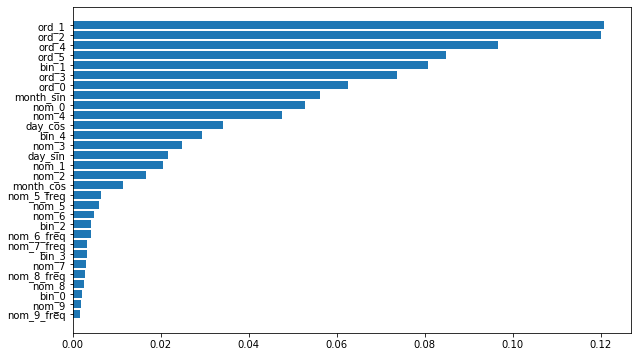

In [109]:
import matplotlib.pyplot as plt

# Let's see the feature importances for checking
imp = pd.Series(
    data=xgb["xgb"].feature_importances_,
    index=data_columns
).sort_values(ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(imp.index, imp)

Conclusion: it seems that high cardinality nominal variables are not so important.

## Now fit the other two models as well

In [75]:
import gc
gc.collect()

40

In [120]:
%%time
# To avoid OOM, we limit the training size.
N_logistic = 50000
choice = np.random.choice(len(X_data), size=N_logistic)

logistic.fit(X_data.loc[choice, :], y_data[choice]);

y_data_hat = logistic.predict_proba(X_data)[:, 1]

# Our final training score for logistic regression
metrics.roc_auc_score(y_data, y_data_hat)

Wall time: 29.4 s


0.7620609770095521

In [121]:
%%time

# For random forest, we use GridSearchCV to tune the parameters.
N_rf = 50000
choice = np.random.choice(len(X_data), size=N_rf)

rf_grid = {
    "clf__n_estimators": [200, 500, 1000, 2000],
    "clf__max_depth": [1, 2],
    "clf__criterion": ["gini", "entropy"]
}
rf_cv = model_selection.GridSearchCV(rf, rf_grid,
        cv=3, scoring="roc_auc")
rf_cv.fit(X_data[:N_rf], y_data[:N_rf])

y_data_hat = rf_cv.predict_proba(X_data)[:, 1]

# Our final training score for RF
metrics.roc_auc_score(y_data, y_data_hat)

Wall time: 2min 39s


0.724727764774564

In [122]:
logistic_proba = logistic.predict_proba(X_test)[:, 1]
xgb_proba = xgb.predict_proba(X_test)[:,1]
rf_proba = rf_cv.predict_proba(X_test)[:, 1]

In [123]:
# Weighted voting
target = 0.7 * xgb_proba + 0.2 * logistic_proba + 0.1 * rf_proba

In [124]:
submission = pd.DataFrame(
    {
        "id": test_id,
        "target": target
    }
)

In [125]:
submission.to_csv("submission.csv", index=False)

Conclusion: this achieves 0.78598 AUC.